In [1]:
import pandas as pd
import numpy as np
from ggplot import *
import glob
import os
import re
import fnmatch

In [2]:
from IPython.display import display
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import seaborn as sns
import string

In [3]:
#the list of training & testing fnames
fnames = sorted(glob.glob('*.csv'))
training_files = [fname for fname in fnames if re.match('(\d*)_main_exp_(\w*)_(\w*)_(\w*)_(\d*_\w*_\d*)_(\d*)_data.csv', fname)]
testing_files = [fname for fname in fnames if re.match('(\d*)_main_exp_(\w*)_(\w*)_(\w*)_(\d*_\w*_\d*)_(\d*).csv', fname)]

In [4]:
#adding file_name colomn to each file
list_of_dfs = [pd.read_csv(fname) for fname in training_files]
for dataframe, fname in zip(list_of_dfs, training_files):
    dataframe['file_name'] = fname

In [5]:
# Combine a list of dataframes, on top of each other
training = pd.concat(list_of_dfs, ignore_index=True)

In [6]:
#merging block_order, block_order_bytype to each training file
info = pd.read_csv("training_fnames_info.csv")
training_data = pd.merge(training,
                 info[['file_name', 'block_order', 'block_order_bytype','subj_id']],
                 on ='file_name')
training_data = training_data.sort_values(by = ['subj_id','block_order'])
training_data = training_data.reset_index(drop = True)
training_data.head()

,pic_index,trial_num,pic_name,rt,resp,feedback_code,feedback,segment,segment_index,pic_type,trial_target,file_name,block_order,block_order_bytype,subj_id
0,1,1,lion,3.416950,space,1,correct,target,NaN,targetNaN,lion,01_main_exp_training_lion_wbuilder_2018_Oct_16...,1.0,1.0,1
1,2,1,coffeepot,4.300220,left,1,correct,path,1.0,path1,lion,01_main_exp_training_lion_wbuilder_2018_Oct_16...,1.0,1.0,1
2,3,1,mosquito,1.366912,left,1,correct,path,2.0,path2,lion,01_main_exp_training_lion_wbuilder_2018_Oct_16...,1.0,1.0,1
3,4,1,canoe,0.750253,right,1,correct,path,3.0,path3,lion,01_main_exp_training_lion_wbuilder_2018_Oct_16...,1.0,1.0,1
4,5,1,goose,7.783490,right,1,correct,decision,1.0,decision1,lion,01_main_exp_training_lion_wbuilder_2018_Oct_16...,1.0,1.0,1


In [7]:
#learning criterion for each subject each block
def trial_criteria (subj_id,block,percentage,criteria):
    
    # select specific subject and block data from trainig_data
    subj_acc = training_data.loc[training_data.subj_id == subj_id]
    block_data = subj_acc.loc[subj_acc.block_order == block]
    block_data = block_data.reset_index(drop = True)
    
    #create a new dataframe that has column of trial_num and percentage of correct feedback
    #for each trial
    block_criteria = pd.DataFrame(columns = ['trial_num','feedback_sum'])
    
    # Get the percentage of correct feedback for each trial
    feedback_sum = []
    for i in range (1,block_data['trial_num'].iloc[-1]+1): # <------- use trial_num as a indicator for iterating through rows
        trial_sum = (block_data.loc[block_data['trial_num'] == i, 'feedback_code'].sum())/12
        feedback_sum.append(trial_sum)
        i += 1 
    block_criteria['trial_num'] = np.arange(len(feedback_sum)) + 1
    block_criteria['feedback_sum'] = feedback_sum

    #count the correct number of trials 
    correct = 0 
    percent = 0
    correct_count = []
    correct_percent = []
    for i in range (0,len(block_criteria)-(criteria-1)):
        iterate_trial = (block_criteria.iloc[i:(i+criteria)])['feedback_sum']
        for iterate_rows in iterate_trial:
            if iterate_rows == 1:
                correct += 1
                percent = correct / criteria
        correct_count.append(correct)
        correct_percent.append(percent)
        correct = 0
        percent = 0
    
    #create a new dataframe that has trial_num, overall_percentage
    overall_criteria = pd.DataFrame(columns = ['trial_criteria','overall_data'])
    overall_criteria['trial_criteria'] = np.arange(len(block_criteria['trial_num'])-(criteria-1)) + 1
    if percentage == 1:
        overall_criteria['overall_data'] = correct_percent
    else:
        overall_criteria['overall_data'] = correct_count
    overall_criteria['trial_target'] = block_data['trial_target'][0] 
    overall_criteria['count'] = correct_count
    overall_criteria['trial_sq'] = overall_criteria['trial_criteria']**2

    return overall_criteria

In [164]:
def trial_criteria_graph(subj_id,criteria):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    plt.title('trial accuracy criteria = ' + str(criteria),loc = 'center')
    for j in range(1,5):
        overall_criteria = trial_criteria (subj_id,j,1,criteria)

        #get regression line for learning criteria
        #change sigmoid    
        formula_criteria = 'overall_data ~ trial_sq + trial_criteria'
        mod = ols(formula=formula_criteria, data=overall_criteria)
        results = mod.fit()
        #print(results.summary())
        predicted = results.predict()
        #print(predicted)

        # scatter plot of learning criteria
        target = overall_criteria['trial_target'][0]
        if target == "arc":
            target = "beaver"
        elif target == "bolt":
            target = "lion"
        axes[j-1].scatter(overall_criteria['trial_criteria'],overall_criteria['overall_data'],label = 'subj_' + str(subj_id) \
                + ', block ' + str(j) + ', ' + 'criteria = ' + str(criteria) + ', '+ target )
        axes[j-1].plot(overall_criteria['trial_criteria'], predicted, linewidth = 3) # <------------- Add predicted values
        axes[j-1].set_xlabel('trial bins') # <--------------- Set x axis label
        axes[j-1].legend(loc = "lower right")
        plt.yticks(np.arange(0, 1.2, step=0.2))
        axes[j-1].set_ylim(0, 1)
        axes[j-1].set_ylabel('Accuracy(percentage)') # <--------- Set y axis label
        j += 1
       
    #save subplots for each subject
    plt.savefig('subj'+str(subj_id)+ '_criteria' + str(criteria) + '_trial_criteria.png')
    plt.close() 


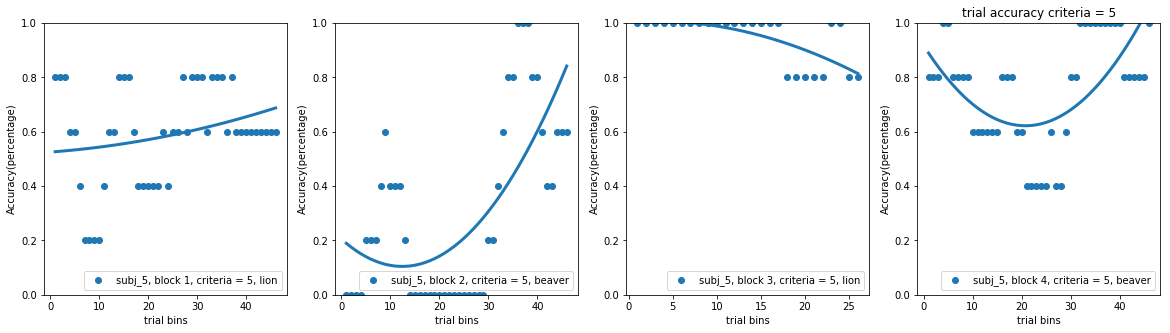

In [156]:
trial_criteria_graph(subj_id = 5,criteria = 5)

In [8]:
#get the max percent of achievement for all subjects
def max_achieved(criteria,subj_bins):
    # create a new df that has max acheived for each block per subject
    block_1 = []
    block_2 = []
    block_3 = []
    block_4 = []
    
    for i in range(1,5):
        for j in range(1,(subj_bins + 1)):
            correct_percent = trial_criteria (subj_id = j,block = i,percentage = 1,criteria = criteria)['overall_data']
            block_max = correct_percent.max()
            if i == 1:
                block_1.append(block_max)
            elif i == 2:
                block_2.append(block_max)
            elif i == 3:
                block_3.append(block_max)
            else:
                block_4.append(block_max)
        if j == 4:
            j = 0
            
    overall_max = pd.DataFrame(columns = ['subj_id','block_1','block_2',
                                          'block_3','block_4'])
    overall_max['subj_id'] = np.arange(1,(subj_bins + 1))
    overall_max['block_1'] = block_1
    overall_max['block_2'] = block_2
    overall_max['block_3'] = block_3
    overall_max['block_4'] = block_4
    return overall_max
            #print(correct_percent)
max_achieved(criteria = 10,subj_bins = 30)

,subj_id,block_1,block_2,block_3,block_4
0,1,0.7,1.0,0.6,1.0
1,2,1.0,1.0,1.0,1.0
2,3,1.0,1.0,0.9,1.0
3,4,1.0,1.0,1.0,1.0
4,5,0.8,0.8,1.0,1.0
5,6,0.7,1.0,0.3,1.0
6,7,1.0,1.0,0.9,0.9
7,8,0.5,1.0,1.0,1.0
8,9,0.8,1.0,1.0,1.0
9,10,1.0,1.0,1.0,1.0


In [128]:
def max_count_hist(criteria):
    max_count = max_achieved(criteria,30)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    axes[0].hist(max_count['block_1'],orientation='vertical',density=True,label = 'block_1')
    axes[1].hist(max_count['block_2'],orientation='vertical',density=True,label = 'block_2')
    axes[2].hist(max_count['block_3'],orientation='vertical',density=True,label = 'block_3')
    axes[3].hist(max_count['block_4'],orientation='vertical',density=True,label = 'block_4')
    
    return fig,axes

(<Figure size 1440x360 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd98bf4ae80>,
       dtype=object))

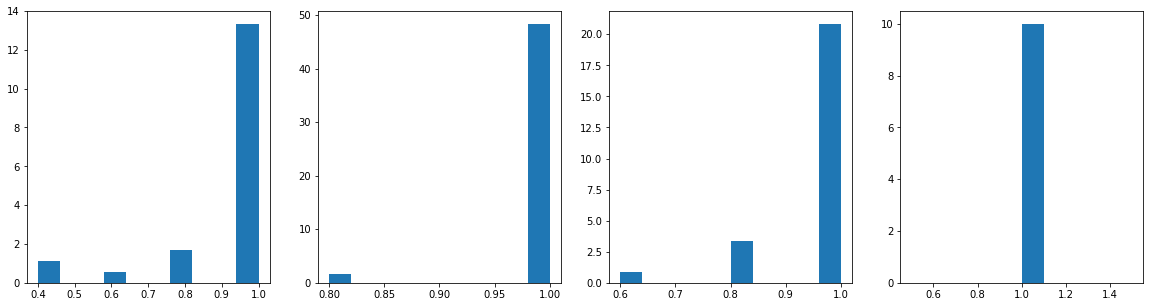

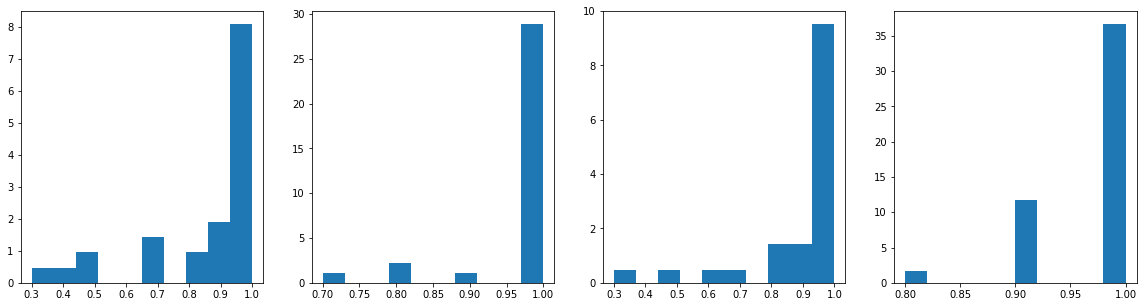

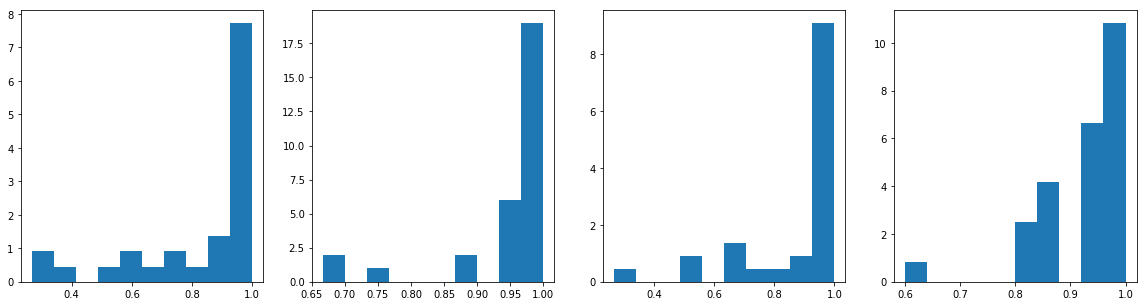

In [129]:
max_count_hist(5)
max_count_hist(10)
max_count_hist(15)

In [ ]:
block_1_percent = max_achieved(10,30)['block_1'].unique().tolist()
block_1_count = max_achieved(10,4)['block_1'].value_counts()
block_count = pd.DataFrame(columns = ['block_1_percent','block_1_count'])
block_count['block_1_percent'] = block_1_percent
block_count['block_1_count'] = block_1_count

In [ ]:
    block_1_count = []
    block_2_count = []
    block_3_count = []
    block_4_count = []
    for i in range(1,5):
        for k in range(0,len(block_1)):
            if i == 1:
                percentage = block_1[k]
                block_count = block_1.count(percentage)
                if 
                block_count = block_1.count('block_1'[k])
                block_1_count.append(block_count) 
            elif i == 2:
                block_count = block_2.count('block_2'[k])
                block_2_count.append(block_count)
            elif i == 3:
                block_count = block_3.count('block_3'[k])
                block_3_count.append(block_count)
            elif i == 4:
                block_count = block_4.count('block_4'[k])
                block_4_count.append(block_count)         
    #create a new df that have each unique percentage value
    max_count_block1 = pd.DataFrame(columns = ['block_1_percentage', 'block_1_count'])
    max_count_block1['block_1_percentage'] = 
                                    


cwd = os.getcwd()
print(cwd)

In [10]:
# get data for d1 and d2
def dpoint_criteria(subj_id,block,criteria):
    # select specific subject and block data from trainig_data
    subj_acc = training_data.loc[training_data.subj_id == subj_id]
    block_data = subj_acc.loc[subj_acc.block_order == block]
    block_data = block_data.reset_index(drop = True)
    
    # select decision 1 and decision 2 rows into two different df
    d1_data = block_data.loc[block_data.pic_type == "decision1"].reset_index(drop = True)
    d2_data = block_data.loc[block_data.pic_type == "decision2"].reset_index(drop = True)
    d1_correct = []
    d2_correct = []
    
    # Decision point 1 correctness
    for i in range(0,len(d1_data)):
        if (d1_data['trial_target'][i] == "lion"):
            if(d1_data['pic_name'][i] == "goose"):
                d1_correct.append(True)
            else:
                d1_correct.append(False)
        elif (d1_data['trial_target'][i] == "bolt"):
            if (d1_data['pic_name'][i] == "domino"):
                d1_correct.append(True)
            else:
                d1_correct.append(False)
        elif (d1_data['trial_target'][i] == "beaver"):
            if(d1_data['pic_name'][i] == "pigeon"):
                d1_correct.append(True)
            else:
                d1_correct.append(False)
        elif (d1_data['trial_target'][i] == "arc"):
            if(d1_data['pic_name'][i] == "watch"):
                d1_correct.append(True)
            else:
                d1_correct.append(False)
    
    # Decision point 2 correctness
    for i in range(0,len(d2_data)):
        if (d2_data['trial_target'][i] == "lion"):
            if(d2_data['pic_name'][i] == "crutches"):
                d2_correct.append(True)
            else:
                d2_correct.append(False)
        elif (d2_data['trial_target'][i] == "bolt"):
            if (d2_data['pic_name'][i] == "garlic"):
                d2_correct.append(True)
            else:
                d2_correct.append(False)
        elif (d2_data['trial_target'][i] == "beaver"):
            if(d2_data['pic_name'][i] == "stepladder"):
                d2_correct.append(True)
            else:
                d2_correct.append(False)
        elif (d2_data['trial_target'][i] == "arc"):
            if(d2_data['pic_name'][i] == "holly"):
                d2_correct.append(True)
            else:
                d2_correct.append(False)
    d1_data['d1_correct'] = (d1_correct)  
    d2_data['d2_correct'] = (d2_correct)  
    
    #count the correct times per criteria
    d1_count = 0 
    d1_percent = 0
    d1_correct_count = []
    d1_correct_percent = []
    d2_count = 0 
    d2_percent = 0
    d2_correct_count = []
    d2_correct_percent = []
    for i in range (0,len(d1_data)-(criteria-1)):
        iterate_dpoint_1 = (d1_data.iloc[i:(i+criteria)])['d1_correct']
        iterate_dpoint_2 = (d2_data.iloc[i:(i+criteria)])['d2_correct']
        for iterate_rows in iterate_dpoint_1:
            if iterate_rows:
                d1_count += 1
                d1_percent = d1_count / criteria
        d1_correct_count.append(d1_count)
        d1_correct_percent.append(d1_percent)
        d1_count = 0
        d1_percent = 0
        for iterate_rows in iterate_dpoint_2:
            if iterate_rows:
                d2_count += 1
                d2_percent = d2_count / criteria
        d2_correct_count.append(d2_count)
        d2_correct_percent.append(d2_percent)
        d2_count = 0
        d2_percent = 0
        
    #create new dataframe for all data
    dpoint_criteria = pd.DataFrame(columns = ['trial_criteria',
                                              'd1_percent','d1_count','d2_percent','d2_count'])
    dpoint_criteria['trial_criteria'] = np.arange(len(d1_data)-(criteria-1)) + 1
    dpoint_criteria['d1_percent'] = d1_correct_percent
    dpoint_criteria['d1_count'] = d1_correct_count
    dpoint_criteria['d2_percent'] = d2_correct_percent
    dpoint_criteria['d2_count'] = d2_correct_count
    dpoint_criteria['trial_target'] = block_data['trial_target'][0] 
    dpoint_criteria['trial_sq'] = dpoint_criteria['trial_criteria']**2
    
    return dpoint_criteria

In [163]:
# graph decision point criteria
def dpoint_criteria_graph(subj_id,criteria):
    # learning curve 
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    plt.title('decision_point accuracy criteria = '+ str(criteria),loc = 'center')
    
    for j in range(1,5):
        overall_criteria = dpoint_criteria(subj_id,j,criteria)
        #create a new df that has trial_num and d1 correct percent
        d1_criteria = pd.DataFrame(columns = ['trial_criteria','trial_sq','d1_percent'])
        d1_criteria['trial_criteria'] = overall_criteria['trial_criteria']
        d1_criteria['trial_sq'] = overall_criteria['trial_sq']
        d1_criteria['d1_percent'] = overall_criteria['d1_percent']
        
        #create a new df that has trial_num and d2 correct percent
        d2_criteria = pd.DataFrame(columns = ['trial_criteria','trial_sq','d2_percent'])
        d2_criteria['trial_criteria'] = overall_criteria['trial_criteria']
        d2_criteria['trial_sq'] = overall_criteria['trial_sq']
        d2_criteria['d2_percent'] = overall_criteria['d2_percent']
        
        #d1_sigmoid
        formula_criteria = 'd1_percent ~ trial_sq + trial_criteria'
        mod_d1 = ols(formula = formula_criteria, data = d1_criteria)
        results_d1 = mod_d1.fit()
        predicted_d1 = results_d1.predict()
        
        #d2_sigmoid
        formula_criteria = 'd2_percent ~ trial_sq + trial_criteria'
        mod_d2 = ols(formula = formula_criteria, data = d2_criteria)
        results_d2 = mod_d2.fit()
        predicted_d2 = results_d2.predict()
        
        # scatter plot of learning criteria
        target = overall_criteria['trial_target'][0]
        if target == "arc":
            target = "beaver"
        elif target == "bolt":
            target = "lion"
       #d1 scatter
        axes[j-1].scatter(d1_criteria['trial_criteria'],d1_criteria['d1_percent'],label = 'subj_' + str(subj_id) \
                + ', block ' + str(j) + ', criteria = ' + str(criteria) +  ', D1 '+ target,color = 'red' )
        axes[j-1].plot(d1_criteria['trial_criteria'], predicted_d1, linewidth = 3, color = 'red') # <------------- Add predicted values
       #d2 scatter
        axes[j-1].scatter(d2_criteria['trial_criteria'],d2_criteria['d2_percent'],label = 'subj_' + str(subj_id) \
                + ', block ' + str(j) + ', criteria = ' + str(criteria) +  ' ,D2 ' + target, color = 'blue')
        axes[j-1].plot(d2_criteria['trial_criteria'], predicted_d2, linewidth = 3, color = 'blue') # <------------- Add predicted values
        axes[j-1].set_xlabel('trial bins') # <--------------- Set x axis label
        axes[j-1].legend(loc = "lower right")
        plt.yticks(np.arange(0, 1.2, step=0.2))
        axes[j-1].set_ylim(0, 1)
        axes[j-1].set_ylabel('Accuracy(percentage)') # <--------- Set y axis label
        j += 1   
        
    #save plots
    plt.savefig('subj'+str(subj_id)+ '_criteria'+ str(criteria)+'_dpoint_criteria.png')
    plt.close() 

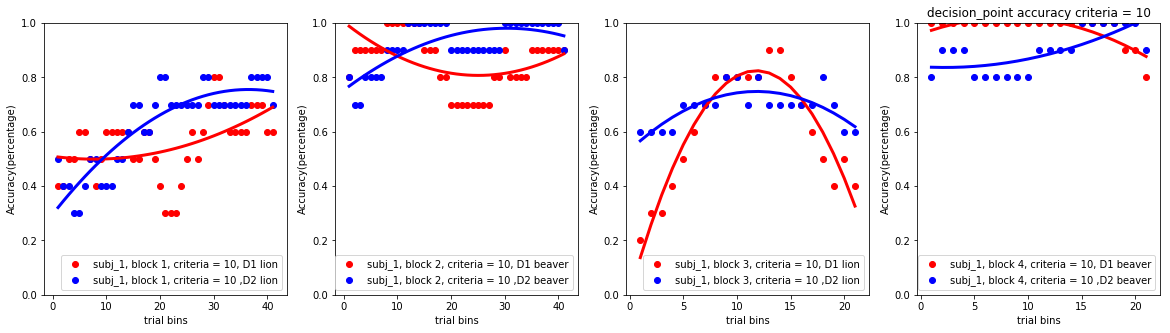

In [154]:
dpoint_criteria_graph(1,10)

In [51]:
# get data for d1 and d2 with specific target 
def target_dpoint_criteria(subj_id,block,criteria):
    # select specific subject and block data from trainig_data
    subj_acc = training_data.loc[training_data.subj_id == subj_id]
    block_data = subj_acc.loc[subj_acc.block_order == block]
    block_data = block_data.reset_index(drop = True)
    
    # select decision 1 and decision 2 rows into two different df
    d1_data = block_data.loc[block_data.pic_type == "decision1"].reset_index(drop = True)
    d2_data = block_data.loc[block_data.pic_type == "decision2"].reset_index(drop = True)
    
    lion_d1_correct = []
    bolt_d1_correct = []
    arc_d1_correct = []
    beaver_d1_correct = []
    
    # Decision point 1 correctness
    for i in range(0,len(d1_data)):
        if (d1_data['trial_target'][i] == "lion"):
            if(d1_data['pic_name'][i] == "goose"):
                lion_d1_correct.append(True)
            else:
                lion_d1_correct.append(False)
        elif (d1_data['trial_target'][i] == "bolt"):
            if (d1_data['pic_name'][i] == "domino"):
                bolt_d1_correct.append(True)
            else:
                bolt_d1_correct.append(False)
        elif (d1_data['trial_target'][i] == "beaver"):
            if(d1_data['pic_name'][i] == "pigeon"):
                beaver_d1_correct.append(True)
            else:
                beaver_d1_correct.append(False)
        elif (d1_data['trial_target'][i] == "arc"):
            if(d1_data['pic_name'][i] == "watch"):
                arc_d1_correct.append(True)
            else:
                arc_d1_correct.append(False)
    
    # Decision point 2 correctness
    lion_d2_correct = []
    bolt_d2_correct = []
    arc_d2_correct = []
    beaver_d2_correct = []
    for i in range(0,len(d2_data)):
        if (d2_data['trial_target'][i] == "lion"):
            if(d2_data['pic_name'][i] == "crutches"):
                lion_d2_correct.append(True)
            else:
                lion_d2_correct.append(False)
        elif (d2_data['trial_target'][i] == "bolt"):
            if (d2_data['pic_name'][i] == "garlic"):
                bolt_d2_correct.append(True)
            else:
                bolt_d2_correct.append(False)
        elif (d2_data['trial_target'][i] == "beaver"):
            if(d2_data['pic_name'][i] == "stepladder"):
                beaver_d2_correct.append(True)
            else:
                beaver_d2_correct.append(False)
        elif (d2_data['trial_target'][i] == "arc"):
            if(d2_data['pic_name'][i] == "holly"):
                arc_d2_correct.append(True)
            else:
                arc_d2_correct.append(False)
                
    # create a new df that has correct counts for different targets
    target_data = pd.DataFrame(columns = ['tg1_d1_correct','tg1_d2_correct',
                                        'tg2_d1_correct','tg2_d2_correct'])
    # Decision 1 data
    if (lion_d1_correct != []):
        # tg1 is lion, tg2 is bolt
        target_data['tg1_d1_correct'] = lion_d1_correct
        target_data['tg2_d1_correct'] = bolt_d1_correct
        target_data['tg1_d2_correct'] = lion_d2_correct
        target_data['tg2_d2_correct'] = bolt_d2_correct
        tg1 = 'lion'
        tg2 = 'bolt'
    elif (arc_d1_correct != []):
         # tg1 is arc, ts2 is beaver
        target_data['tg1_d1_correct'] = arc_d1_correct
        target_data['tg2_d1_correct'] = beaver_d1_correct
        target_data['tg1_d2_correct'] = arc_d2_correct
        target_data['tg2_d2_correct'] = beaver_d2_correct
        tg1 = 'arc'
        tg2 = 'beaver'
            
    tg1_d1_count = 0
    tg1_d2_count = 0
    tg2_d1_count = 0
    tg2_d2_count = 0
    tg1_d1_percent = 0
    tg1_d2_percent = 0
    tg2_d1_percent = 0
    tg2_d2_percent = 0
    tg1_d1_correct = []
    tg1_d1_correct_percent = []
    tg1_d2_correct = []
    tg1_d2_correct_percent = []
    tg2_d1_correct = []
    tg2_d1_correct_percent = []
    tg2_d2_correct = []
    tg2_d2_correct_percent = []

    for i in range (0,len(target_data)-(criteria-1)):
        iterate_dpoint_1_tg1 = (target_data.iloc[i:(i+criteria)])['tg1_d1_correct']
        iterate_dpoint_2_tg1 = (target_data.iloc[i:(i+criteria)])['tg1_d2_correct']
        iterate_dpoint_1_tg2 = (target_data.iloc[i:(i+criteria)])['tg2_d1_correct']
        iterate_dpoint_2_tg2 = (target_data.iloc[i:(i+criteria)])['tg2_d2_correct']
        
        #criteria for target 1 , decision point 1
        for iterate_rows in iterate_dpoint_1_tg1:
            if iterate_rows:
                tg1_d1_count += 1
                tg1_d1_percent = tg1_d1_count / criteria
        tg1_d1_correct.append(tg1_d1_count)
        tg1_d1_correct_percent.append(tg1_d1_percent)
        tg1_d1_count = 0
        tg1_d1_percent = 0
        
        #criteria for target 1, decision point 2
        for iterate_rows in iterate_dpoint_2_tg1:
            if iterate_rows:
                tg1_d2_count += 1
                tg1_d2_percent = tg1_d2_count / criteria
        tg1_d2_correct.append(tg1_d2_count)
        tg1_d2_correct_percent.append(tg1_d2_percent)
        tg1_d2_count = 0
        tg1_d2_percent = 0
        
        # criteria for target 2, decision point 1
        for iterate_rows in iterate_dpoint_1_tg2:
            if iterate_rows:
                tg2_d1_count += 1
                tg2_d1_percent = tg2_d1_count / criteria
        tg2_d1_correct.append(tg2_d1_count)
        tg2_d1_correct_percent.append(tg2_d1_percent)
        tg2_d1_count = 0
        tg2_d1_percent = 0
        
        # criteria for target 2, decision point 2
        for iterate_rows in iterate_dpoint_2_tg2:
            if iterate_rows:
                tg2_d2_count += 1
                tg2_d2_percent = tg2_d2_count / criteria
        tg2_d2_correct.append(tg2_d2_count)
        tg2_d2_correct_percent.append(tg2_d2_percent)
        tg2_d2_count = 0
        tg2_d2_percent = 0
    
    #create new dataframe for all data
    target_dpoint_criteria = pd.DataFrame(columns = ['trial_criteria',
                                              'tg1_d1_percent','tg1_d2_percent','tg2_d1_percent','tg2_d2_percent'])
    target_dpoint_criteria['trial_criteria'] = np.arange(len(target_data)-(criteria-1)) + 1
    target_dpoint_criteria['tg1_d1_percent'] = tg1_d1_correct_percent
    target_dpoint_criteria['tg1_d2_percent'] = tg1_d2_correct_percent
    target_dpoint_criteria['tg2_d1_percent'] = tg2_d1_correct_percent
    target_dpoint_criteria['tg2_d2_percent'] = tg2_d2_correct_percent
    target_dpoint_criteria['trial_target1'] = tg1
    target_dpoint_criteria['trial_target2'] = tg2
    target_dpoint_criteria['trial_sq'] = target_dpoint_criteria['trial_criteria']**2
    
    return target_dpoint_criteria

In [135]:
target_dpoint_criteria(subj_id = 12,block = 4,criteria = 5)

,trial_criteria,tg1_d1_percent,tg1_d2_percent,tg2_d1_percent,tg2_d2_percent,trial_target1,trial_target2,trial_sq
0,1,0,0,1.0,1.0,arc,beaver,1
1,2,0,0,1.0,1.0,arc,beaver,4
2,3,0,0,1.0,1.0,arc,beaver,9
3,4,0,0,1.0,1.0,arc,beaver,16
4,5,0,0,1.0,1.0,arc,beaver,25
5,6,0,0,1.0,1.0,arc,beaver,36


In [159]:
# graph decision point for each target criteria
def target_dpoint_criteria_graph(subj_id,criteria):
    # learning curve 
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10)) #vertical 10,20
    plt.title('target_decision_point accuracy criteria = '+ str(criteria),loc = 'center')
    
    for j in range(1,5):
        overall_criteria = target_dpoint_criteria(subj_id,j,criteria)
        
        #create a new df that has trial_num and d1 tg1 correct percent
        tg1_d1_criteria = pd.DataFrame(columns = ['trial_criteria','trial_sq','tg1_d1_percent'])
        tg1_d1_criteria['trial_criteria'] = overall_criteria['trial_criteria']
        tg1_d1_criteria['trial_sq'] = overall_criteria['trial_sq']
        tg1_d1_criteria['tg1_d1_percent'] = overall_criteria['tg1_d1_percent']
        
        #create a new df that has trial_num and d2 tg1 correct percent
        tg1_d2_criteria = pd.DataFrame(columns = ['trial_criteria','trial_sq','tg1_d2_percent'])
        tg1_d2_criteria['trial_criteria'] = overall_criteria['trial_criteria']
        tg1_d2_criteria['trial_sq'] = overall_criteria['trial_sq']
        tg1_d2_criteria['tg1_d2_percent'] = overall_criteria['tg1_d2_percent']
        
        #create a new df that has trial_num and d1 tg1 correct percent
        tg2_d1_criteria = pd.DataFrame(columns = ['trial_criteria','trial_sq','tg2_d1_percent'])
        tg2_d1_criteria['trial_criteria'] = overall_criteria['trial_criteria']
        tg2_d1_criteria['trial_sq'] = overall_criteria['trial_sq']
        tg2_d1_criteria['tg2_d1_percent'] = overall_criteria['tg2_d1_percent']
        
        #create a new df that has trial_num and d2 tg1 correct percent
        tg2_d2_criteria = pd.DataFrame(columns = ['trial_criteria','trial_sq','tg2_d2_percent'])
        tg2_d2_criteria['trial_criteria'] = overall_criteria['trial_criteria']
        tg2_d2_criteria['trial_sq'] = overall_criteria['trial_sq']
        tg2_d2_criteria['tg2_d2_percent'] = overall_criteria['tg2_d2_percent']
        
        #tg1_d1_sigmoid
        formula_criteria = 'tg1_d1_percent ~ trial_sq + trial_criteria'
        mod_tg1_d1 = ols(formula = formula_criteria, data = tg1_d1_criteria)
        results_tg1_d1 = mod_tg1_d1.fit()
        tg1_d1_predicted = results_tg1_d1.predict()
        
        #tg1_d2_sigmoid
        formula_criteria = 'tg1_d2_percent ~ trial_sq + trial_criteria'
        mod_tg1_d2 = ols(formula = formula_criteria, data = tg1_d2_criteria)
        results_tg1_d2 = mod_tg1_d2.fit()
        tg1_d2_predicted = results_tg1_d2.predict()
        
        #tg2_d1_sigmoid
        formula_criteria = 'tg2_d1_percent ~ trial_sq + trial_criteria'
        mod_tg2_d1 = ols(formula = formula_criteria, data = tg2_d1_criteria)
        results_tg2_d1 = mod_tg2_d1.fit()
        tg2_d1_predicted = results_tg2_d1.predict()
        
        #tg1_d2_sigmoid
        formula_criteria = 'tg2_d2_percent ~ trial_sq + trial_criteria'
        mod_tg2_d2 = ols(formula = formula_criteria, data = tg2_d2_criteria)
        results_tg2_d2 = mod_tg2_d2.fit()
        tg2_d2_predicted = results_tg2_d2.predict()
       
        tg1 = overall_criteria['trial_target1'][0]
        tg2 = overall_criteria['trial_target2'][0]
       #tg1 d1 scatter
        axes[0,j-1].scatter(tg1_d1_criteria['trial_criteria'],tg1_d1_criteria['tg1_d1_percent'],label = 'subj_' + str(subj_id) \
            + ', block ' + str(j)  + ', criteria = ' + str(criteria)+  ' ,D1 '+ tg1,color = 'red' )
        axes[0,j-1].plot(tg1_d1_criteria['trial_criteria'], tg1_d1_predicted, linewidth = 3, color = 'red') # <------------- Add predicted values
       #tg1 d2 scatter
        axes[0,j-1].scatter(tg1_d2_criteria['trial_criteria'],tg1_d2_criteria['tg1_d2_percent'],label = 'subj_' + str(subj_id) \
            + ', block ' + str(j)  + ', criteria = ' + str(criteria)+  ' ,D2 ' + tg1, color = 'blue')
        axes[0,j-1].plot(tg1_d2_criteria['trial_criteria'], tg1_d2_predicted, linewidth = 3, color = 'blue') # <------------- Add predicted values
        axes[0,j-1].set_xlabel('trial bins') # <--------------- Set x axis label
        axes[0,j-1].legend(loc = "lower right")
        plt.yticks(np.arange(0, 1.2, step=0.2))
        axes[0,j-1].set_ylim(0, 1)
        axes[0,j-1].set_ylabel('Accuracy(percentage)') # <--------- Set y axis label
        #tg2 d1 scatter
        axes[1,j-1].scatter(tg2_d1_criteria['trial_criteria'],tg2_d1_criteria['tg2_d1_percent'],label = 'subj_' + str(subj_id) \
            + ', block ' + str(j) + ', criteria = ' + str(criteria)+ ' ,D1 '+ tg2,color = 'red' )
        axes[1,j-1].plot(tg2_d1_criteria['trial_criteria'], tg2_d1_predicted, linewidth = 3, color = 'red') # <------------- Add predicted values
       #tg2 d2 scatter
        axes[1,j-1].scatter(tg2_d2_criteria['trial_criteria'],tg2_d2_criteria['tg2_d2_percent'],label = 'subj_' + str(subj_id) \
            + ', block ' + str(j)  + ', criteria = ' + str(criteria)+  ' ,D2 ' + tg2, color = 'blue')
        axes[1,j-1].plot(tg2_d2_criteria['trial_criteria'], tg2_d2_predicted, linewidth = 3, color = 'blue') # <------------- Add predicted values
        axes[1,j-1].set_xlabel('trial bins') # <--------------- Set x axis label
        axes[1,j-1].legend(loc = "lower right")
        plt.yticks(np.arange(0, 1.2, step=0.2))
        axes[1,j-1].set_ylim(0, 1)
        axes[1,j-1].set_ylabel('Accuracy(percentage)') # <--------- Set y axis label
        j += 1
    #save plots
    plt.savefig('subj'+str(subj_id)+'_criteria'+ str(criteria)+ '_tg_dpoint_criteria.png')
    plt.close() 

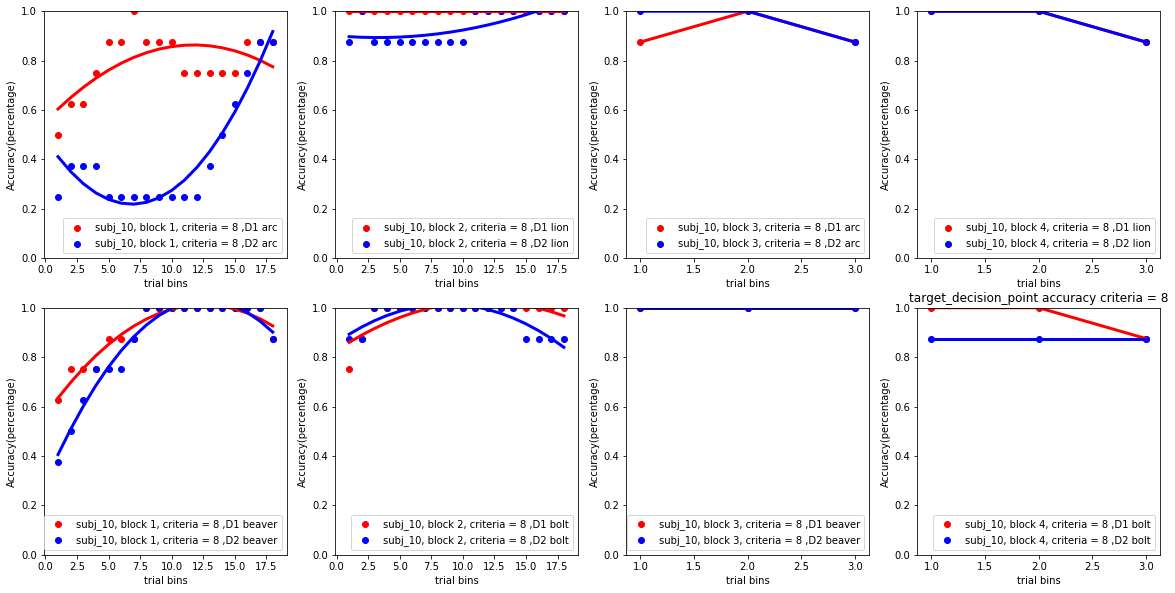

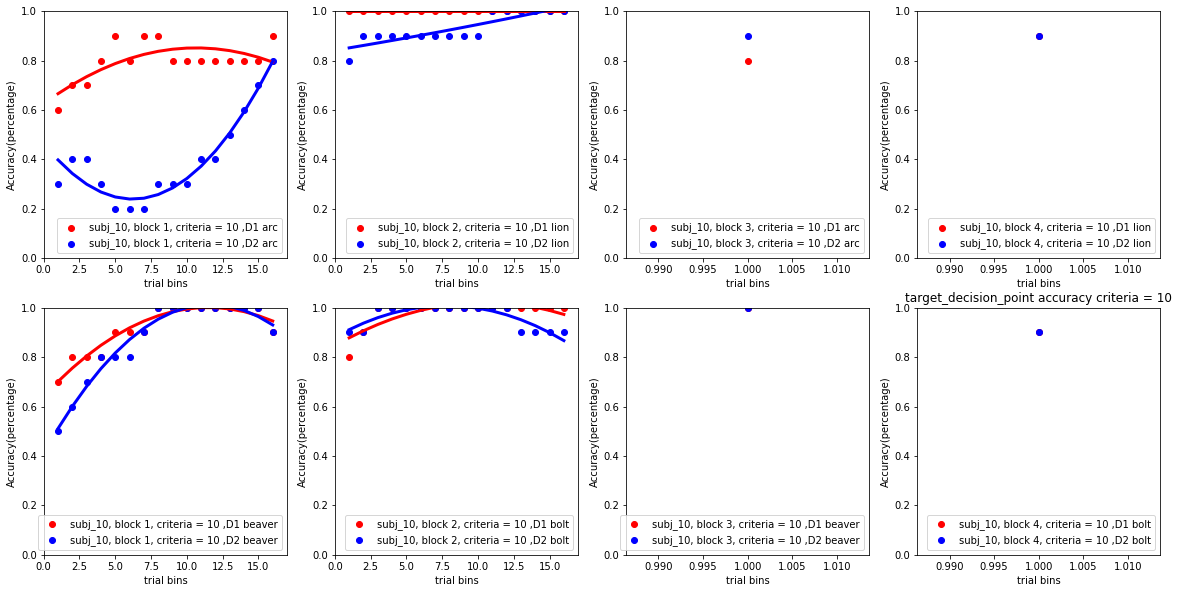

In [157]:
target_dpoint_criteria_graph(subj_id = 10,criteria = 8)
target_dpoint_criteria_graph(subj_id = 10,criteria = 10)

In [167]:
#save scatter subplots for all subjects
def graph_all():
    for i in range (1,31):
        #trial_criteria_graph(subj_id = i,criteria = 8)
        #trial_criteria_graph(i,criteria = 8)
        dpoint_criteria_graph(subj_id = i,criteria = 8)
        #dpoint_criteria_graph(subj_id = 10,criteria = 8)
        #target_dpoint_criteria_graph(subj_id = i,criteria = 5)
        #target_dpoint_criteria_graph(subj_id = i,criteria = 8)
        #target_dpoint_criteria_graph(subj_id = i,criteria = 10)
        
graph_all()

In [ ]:
dpoint_criteria(subj_id=1,block=1,criteria = 8)

In [9]:
subj_acc = training_data.loc[training_data.subj_id == 1]
block_data = subj_acc.loc[subj_acc.block_order == 3]
block_data = block_data.reset_index(drop = True)
feedback_sum = []
for i in range (1,block_data['trial_num'].iloc[-1]+1): # <------- use trial_num as a indicator for iterating through rows
    trial_sum = block_data.loc[block_data['trial_num'] == i, 'feedback_code'].sum()/12
    feedback_sum.append(trial_sum)
    i += 1

block_criteria = pd.DataFrame(columns = ['trial_num','feedback_sum'])
block_criteria['trial_num'] = np.arange(len(feedback_sum)) + 1
block_criteria['feedback_sum'] = feedback_sum

correct = 0
percent = 0
correct_percent = []
correct_count = []
for i in range (0,len(block_criteria)-4):
    iterate_5trial = (block_criteria.iloc[i:(i+5)])['feedback_sum']
    for iterate_rows in iterate_5trial:
        if iterate_rows == 1:
            correct += 1
            percent = correct / 5
    correct_count.append(correct)
    correct_percent.append(percent)
    correct = 0
    percent = 0

dPoint_data = block_data.loc[block_data.pic_type == "decision1"]
dPoint_data = dPoint_data.reset_index(drop = True)


In [ ]:
# Retrieval phase
# Count the total of correct hit, miss and incorrect hit for each block
correct = 0
incorrect = 0
miss = 0
for i in range (0,len(feedback_sum)):
    if feedback_sum[i] == 1:
        correct += 1
    elif feedback_sum[i] == -1:
        incorrect += 1
    else: 
        miss += 1
total_trials = block_criteria['trial_num'].iloc[-1]

#create a bar graph that has correct hit, miss and incorrect hit
x = ['correct','incorrect','miss']
y = [correct,incorrect,miss]
axes[1] = plt.bar(x, height=y, width=.4)
for bar in axes[1]:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .008, yval)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))    

In [77]:
#get regression line for learning criteria
overall_criteria['trial_sq'] = overall_criteria['trial_criteria']**2
formula_criteria = 'overall_percentage ~ trial_sq + trial_criteria'
mod = ols(formula=formula_criteria, data=overall_criteria)
results = mod.fit()
print(results.summary())
predicted = results.predict()
print(predicted)

                            OLS Regression Results                            
Dep. Variable:     overall_percentage   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     23.78
Date:                Thu, 29 Aug 2019   Prob (F-statistic):           1.11e-07
Time:                        15:26:31   Log-Likelihood:                -15.308
No. Observations:                  46   AIC:                             36.62
Df Residuals:                      43   BIC:                             42.10
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5541      0.148     -3.

In [ ]:
#create a pie chart that has percentage of correct hit, miss and incorrect hit
    labels = 'correct', 'incorrect', 'miss'
    sizes = [correct / total_trials, incorrect / total_trials, miss / total_trials]
    explode = (0.1, 0, 0)  
    
    axes[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axes[2].axis('equal') 
    plt.show()